# Lotka-Volterra model

- simulator taken from https://github.com/mackelab/SNL_py3port, which contains the original https://github.com/gpapamak/snl after 2to3 conversion with minimal edits (deactivating generator-internal summary stats normalization).
- WIP (posteriors look terrible atm)

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import timeit

from delfi.utils.viz import plot_pdf
import delfi.inference as infer
import delfi.distribution as dd

from lfimodels.snl_exps.util import save_results, load_results
from lfimodels.snl_exps.util import init_g_lv as init_g
from lfimodels.snl_exps.util import load_setup_lv as load_setup
from lfimodels.snl_exps.util import load_gt_lv as load_gt
from lfimodels.snl_exps.util import calc_all_lprob_errs

seed = 42

model_id = 'lv'
save_path = 'results/' + model_id
exp_id = 'seed'+str(seed)



# simulation setup
setup_dict = load_setup()

pars_true, obs_stats = load_gt(generator=init_g(seed=seed))
print('pars_true : ', pars_true)
print('obs_stats : ', obs_stats)



 Sampling xo instead !
pars_true :  [-4.60517019 -0.69314718  0.         -4.60517019]
obs_stats :  [[9.52251656e+01 5.19668874e+01 8.67364561e+00 8.05149566e+00
  9.80002316e-01 9.34987651e-01 9.77287472e-01 9.26921876e-01
  2.29361846e-02]]


# fit SNPE-C

In [2]:
if setup_dict['train_on_all']:
    epochs=[setup_dict['epochs']//(r+1) for r in range(setup_dict['n_rounds'])]
else:
    epochs=setup_dict['epochs']

# control MAF seed
rng = np.random
rng.seed(seed)

# generator
g = init_g(seed=seed)
    
res_C = infer.SNPEC(g,
                    obs=obs_stats,
                    n_hiddens=setup_dict['n_hiddens'],
                    seed=seed,
                    reg_lambda=setup_dict['reg_lambda'],
                    pilot_samples=setup_dict['pilot_samples'],
                    svi=setup_dict['svi'],
                    n_mades=setup_dict['n_mades'],
                    act_fun=setup_dict['act_fun'],
                    mode=setup_dict['mode'],
                    rng=rng,
                    batch_norm=setup_dict['batch_norm'],
                    verbose=setup_dict['verbose'],
                    prior_norm=setup_dict['prior_norm'])


# train
t = timeit.time.time()

print('fitting model with SNPC-C')
logs_C, tds_C, posteriors_C = res_C.run(
                    n_train=setup_dict['n_train'],
                    proposal=setup_dict['proposal'],
                    moo=setup_dict['moo'],
                    n_null = setup_dict['n_null'],
                    n_rounds=setup_dict['n_rounds'],
                    train_on_all=setup_dict['train_on_all'],
                    minibatch=setup_dict['minibatch'],
                    epochs=epochs)

print('fitting time : ', timeit.time.time() - t)

/home/marcel/Desktop/Projects/Biophysicality/code/snl_py3/snl/ml/models/mafs.py:231: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  output_order = output_order if output_order == 'random' else made.output_order[::-1]



fitting model with SNPC-C



combining data ...
n_train_round 1000


/home/marcel/anaconda/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "



combining data ...
n_train_round 2000



combining data ...
n_train_round 3000



combining data ...
n_train_round 4000



combining data ...
n_train_round 5000



combining data ...
n_train_round 6000



combining data ...
n_train_round 7000



combining data ...
n_train_round 8000



combining data ...
n_train_round 9000



combining data ...
n_train_round 10000
fitting time :  10010.153084754944


# inspect results

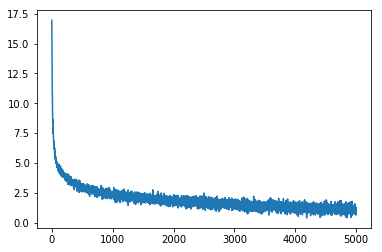

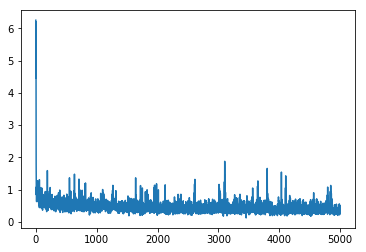

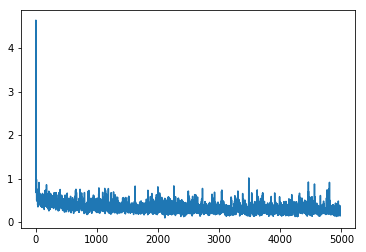

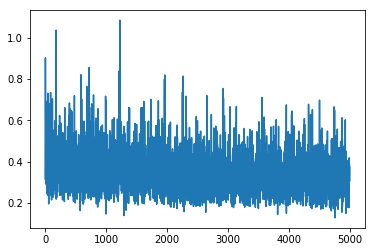

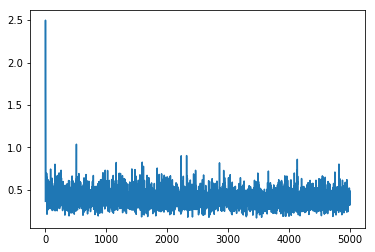

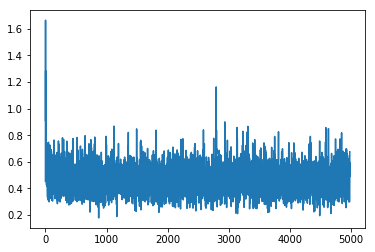

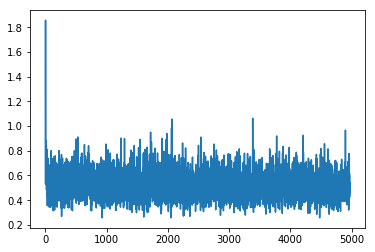

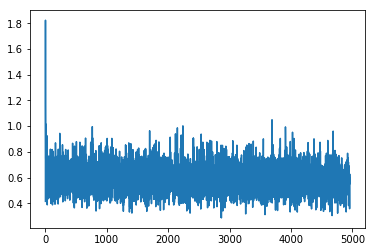

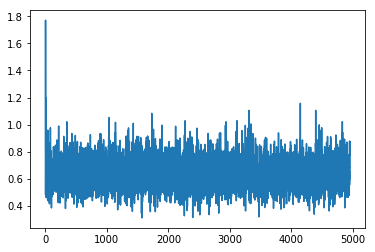

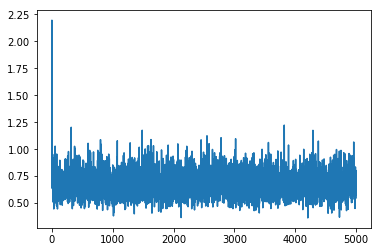

/home/marcel/anaconda/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/marcel/anaconda/lib/python3.7/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


negative log-probability of ground-truth pars 
 19.282317267458097



negative log-probability of ground-truth pars 
 2.289378793533397



negative log-probability of ground-truth pars 
 -4.5201802814185665



negative log-probability of ground-truth pars 
 -4.897888350467722



negative log-probability of ground-truth pars 
 -5.976593713694662



negative log-probability of ground-truth pars 
 -4.9760574725465165



negative log-probability of ground-truth pars 
 -4.573477065560097



negative log-probability of ground-truth pars 
 -3.7133550828167285



negative log-probability of ground-truth pars 
 -2.451105007942491



negative log-probability of ground-truth pars 
 -1.6339901725880912


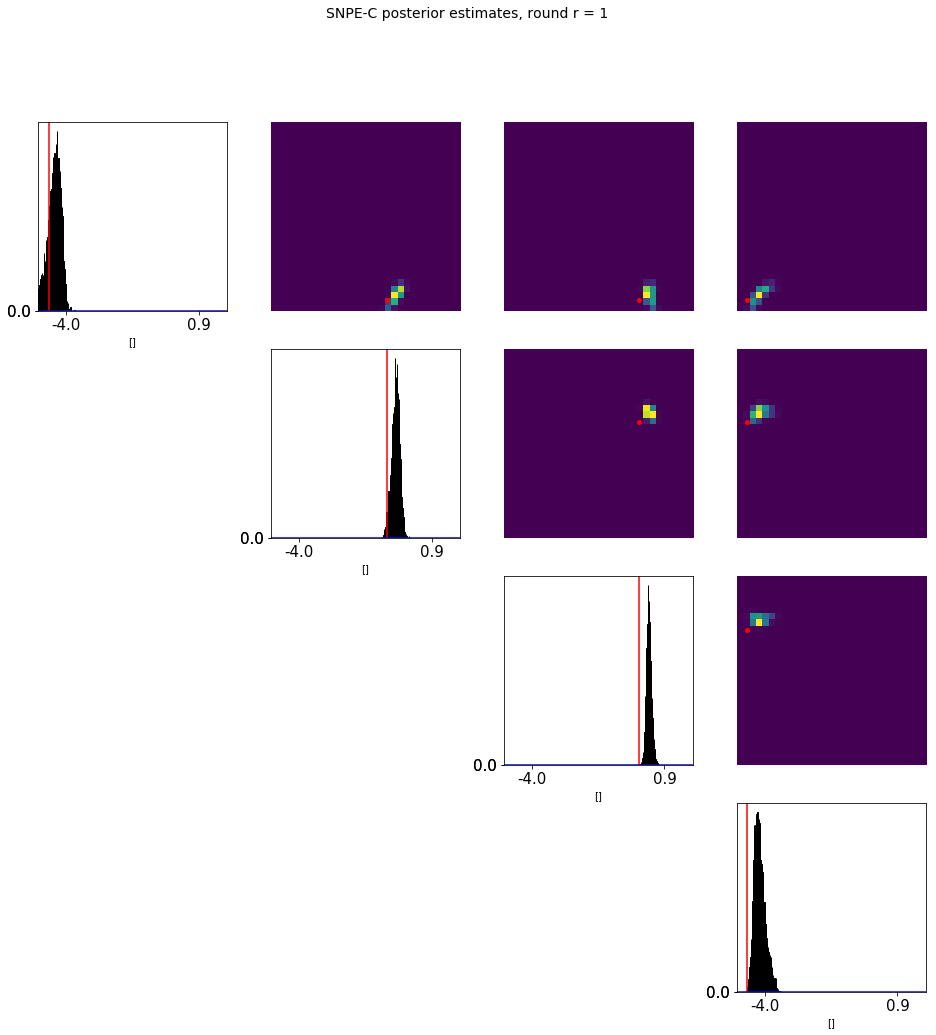

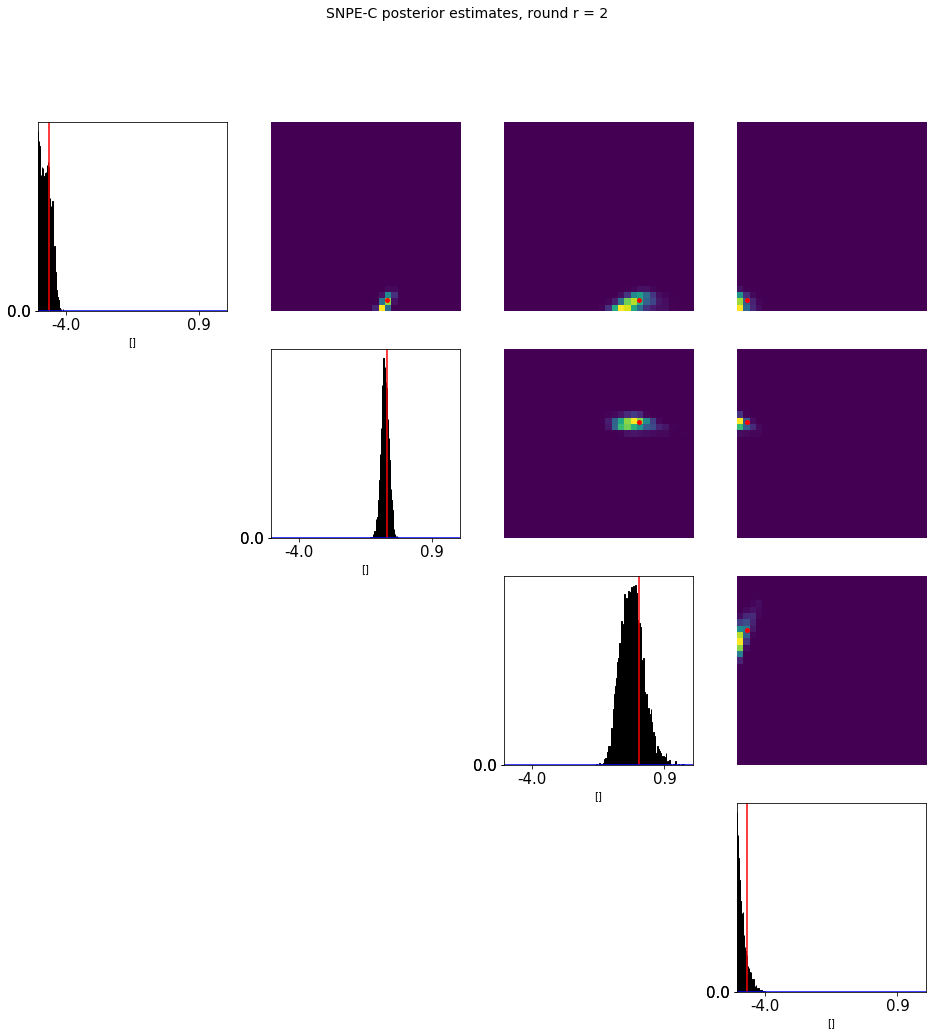

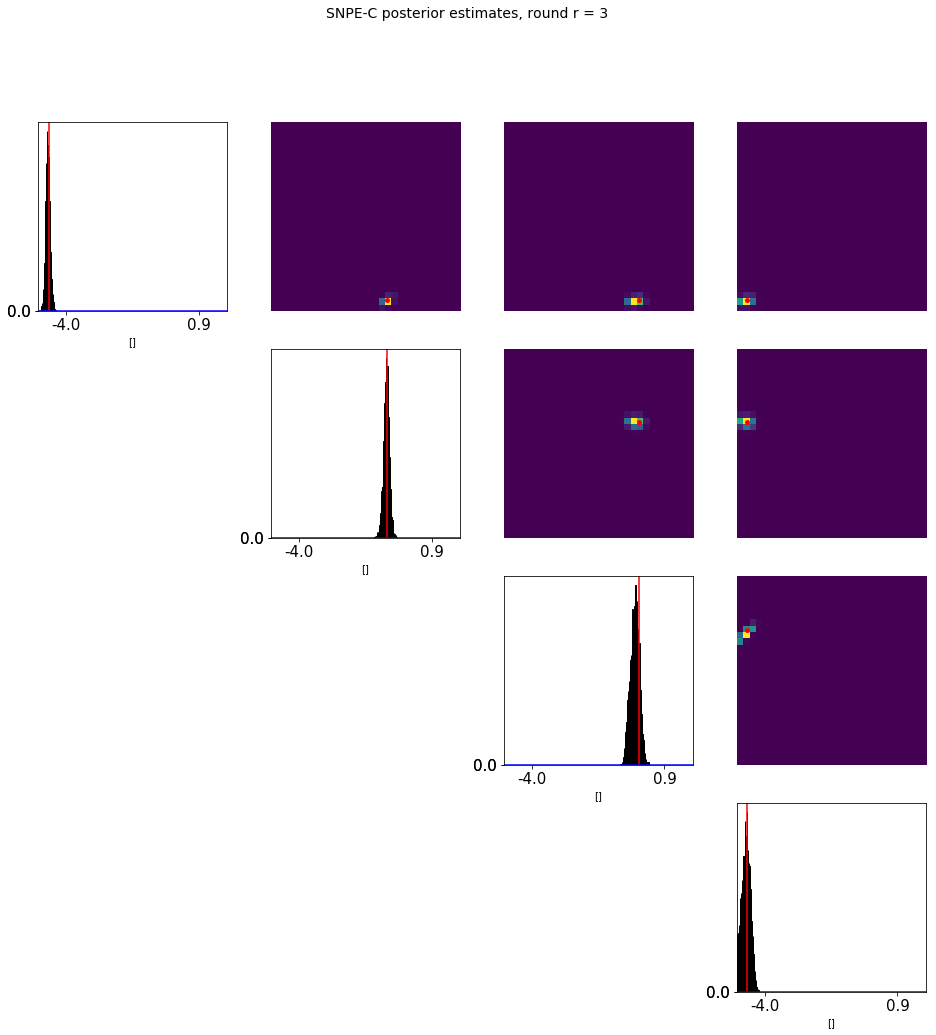

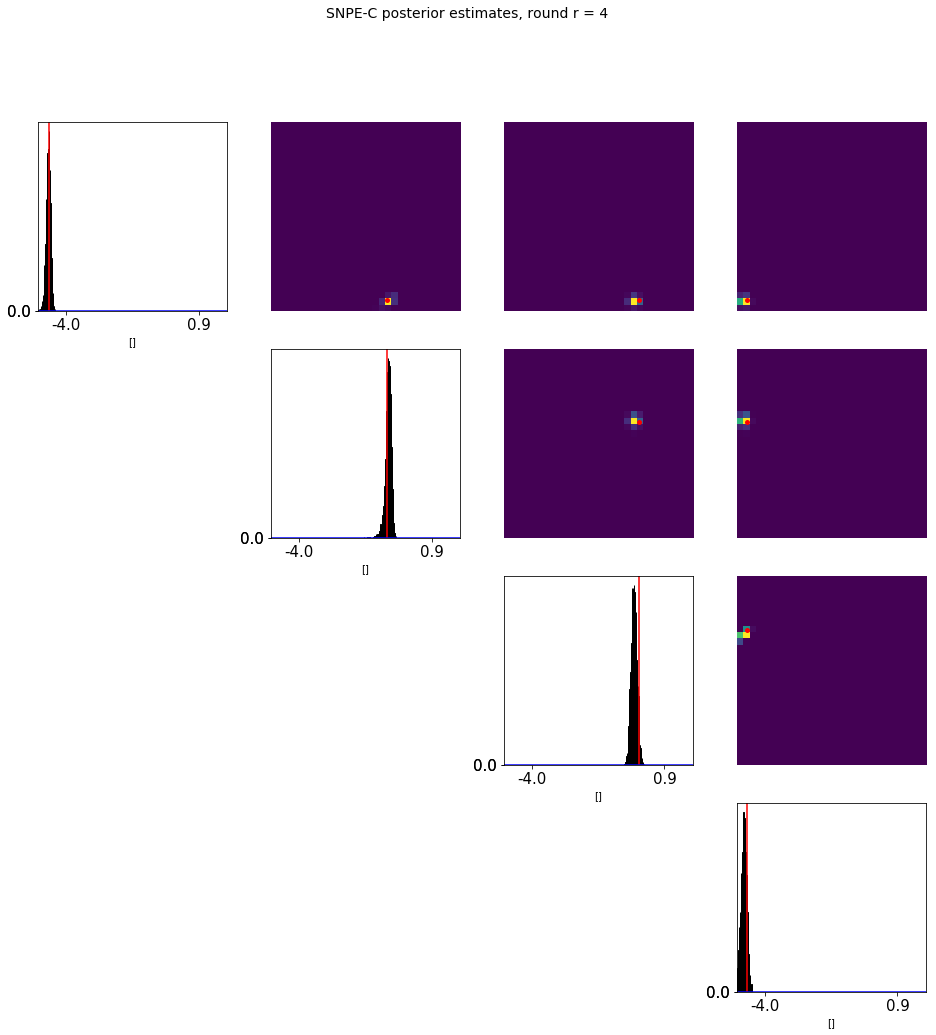

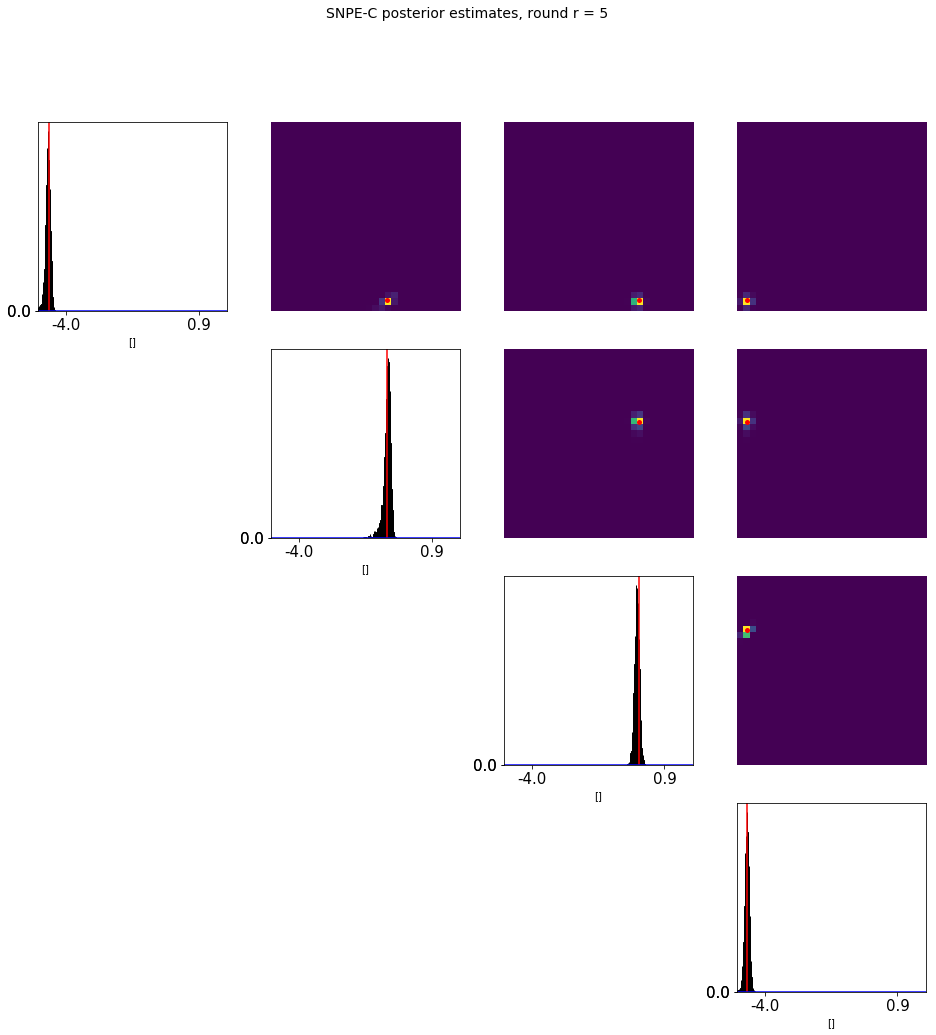

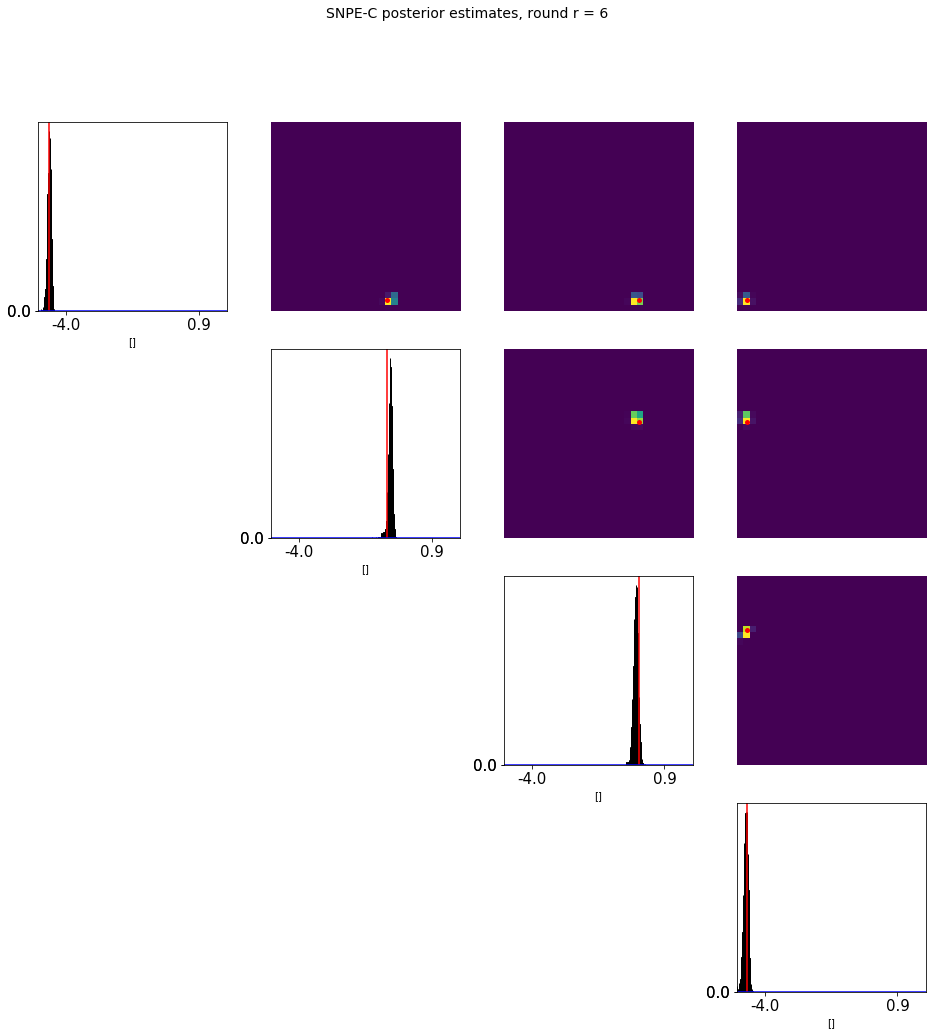

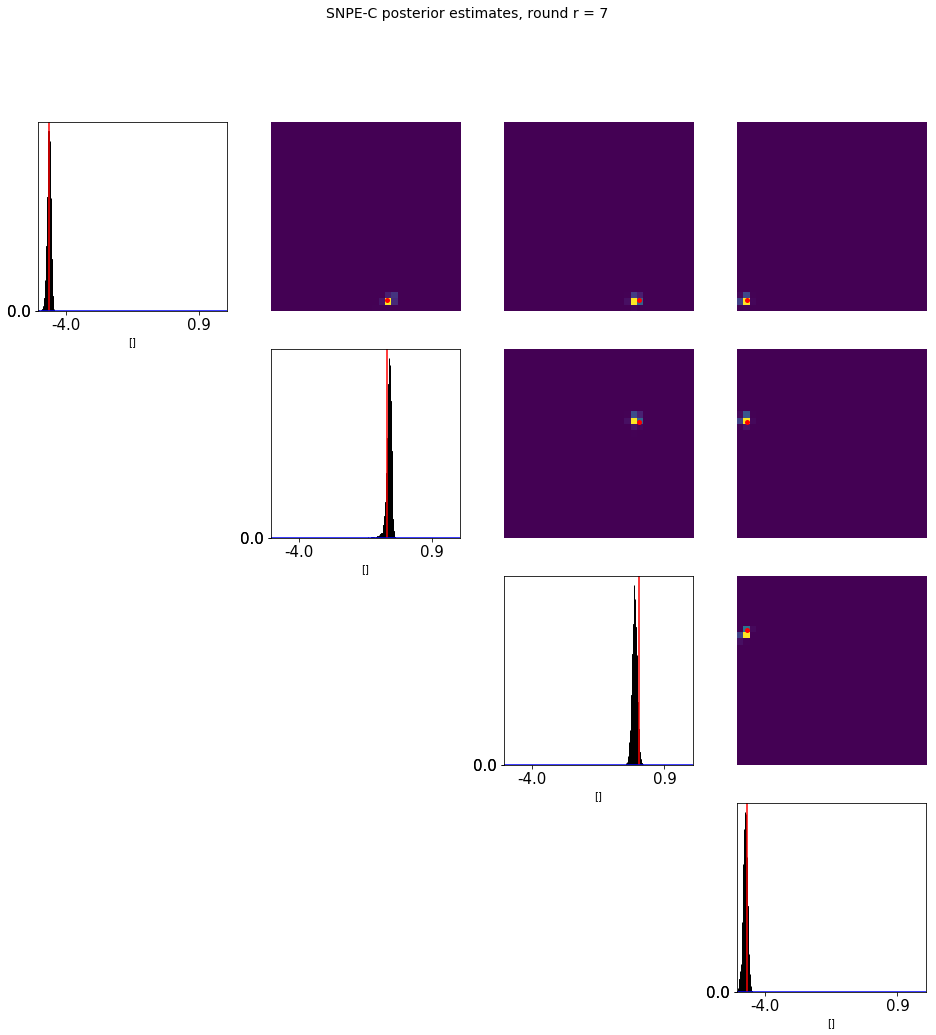

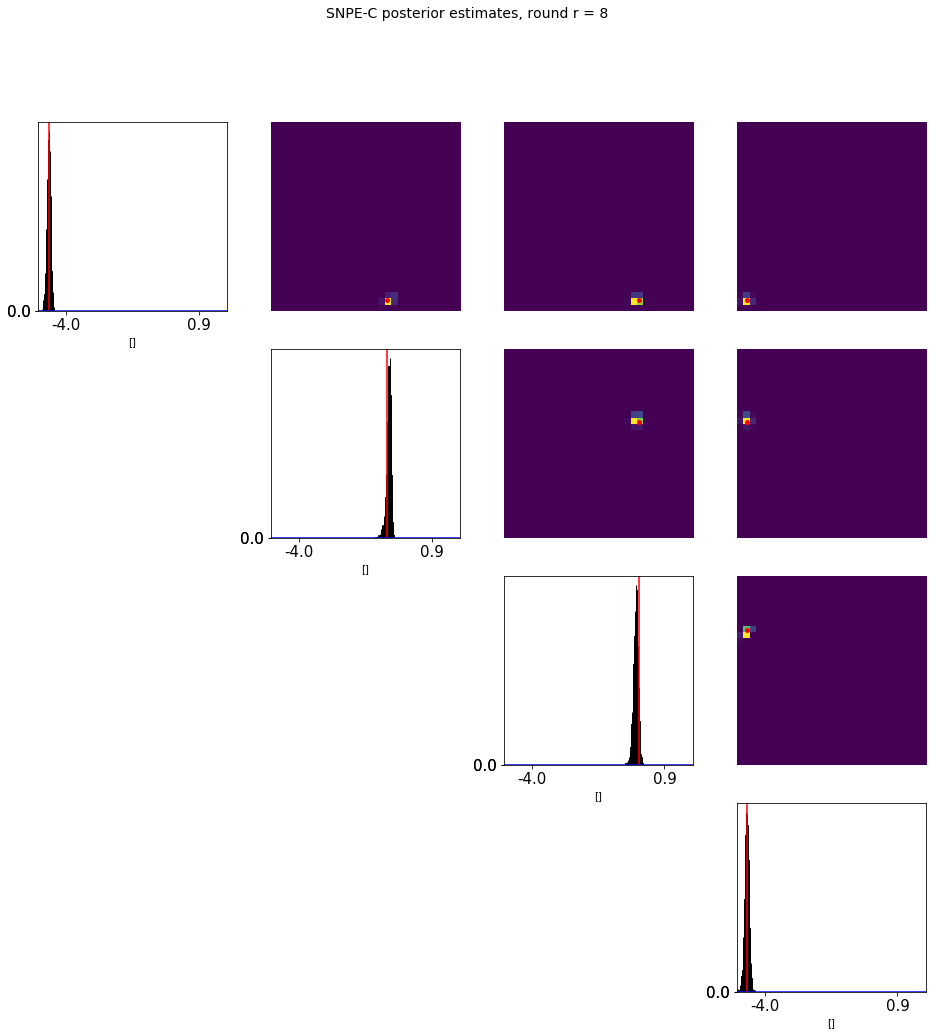

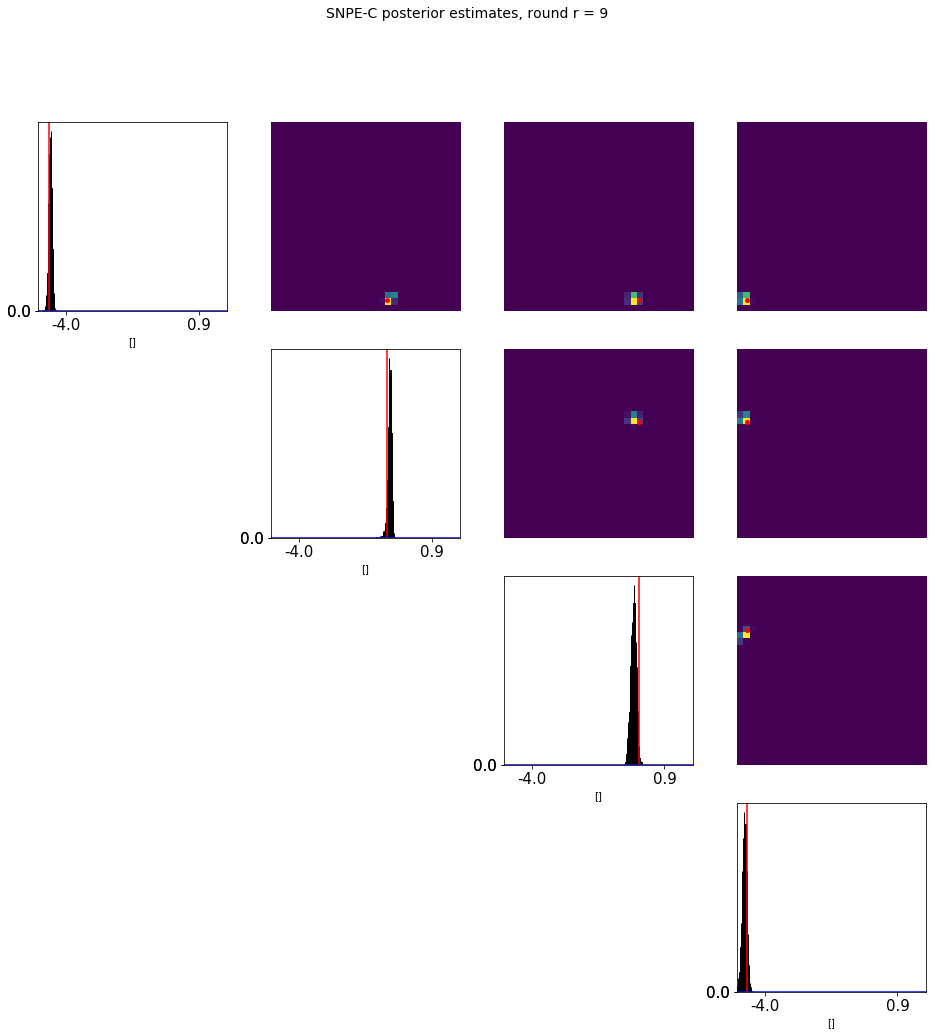

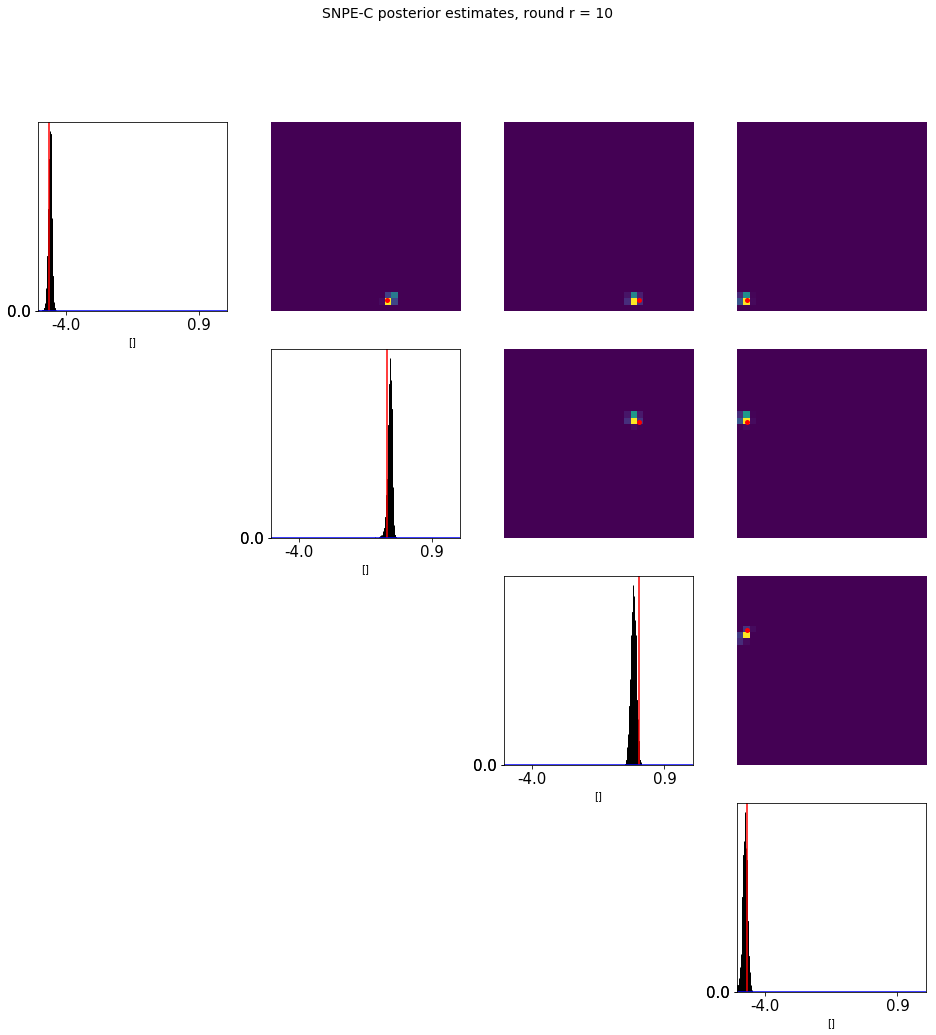

In [7]:
for r in range(setup_dict['n_rounds']):
    plt.plot(logs_C[r]['loss'])
    plt.show()

for r in range(len(logs_C)):
    
    posterior_C = posteriors_C[r]
    #posterior_C.ndim = posterior_A.ndim
    
    g = init_g(seed=42)
    g.proposal = posterior_C
    samples = np.array(g.draw_params(5000)) 
    
    fig,_ = plot_pdf(dd.Gaussian(m=0.00000123*np.ones(pars_true.size), S=1e-30*np.eye(pars_true.size)), 
                   samples=samples.T,
                   gt=pars_true, 
                   lims=[[-5,2],[-5,2],[-5,2],[-5,2]],
                   #lims=[0,10],
                   resolution=100,
                   ticks=True,
                   figsize=(16,16));
    
    fig.suptitle('SNPE-C posterior estimates, round r = '+str(r+1), fontsize=14)
    print('negative log-probability of ground-truth pars \n', -posterior_C.eval(pars_true, log=True))

# marginal over summary statistics (plus best-fitting Gaussian approx.)

/home/marcel/anaconda/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/marcel/anaconda/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


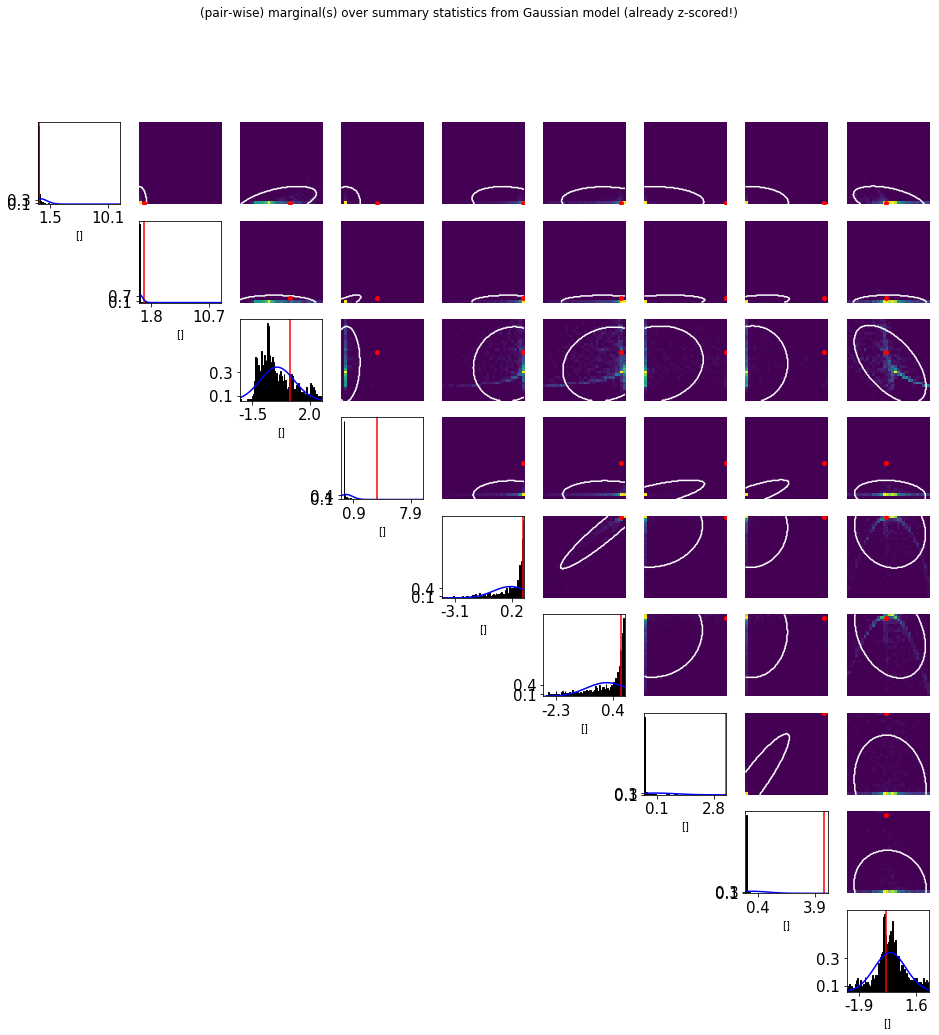

In [5]:
stats = tds_C[0][1]
fig,_ = plot_pdf(dd.Gaussian(m=stats.mean(axis=0), S=np.cov(stats.T)), 
                   samples=stats.T,
                   gt=((obs_stats-res_C.stats_mean)/res_C.stats_std).flatten(), 
                   ticks=True,
                   resolution=100,
                   figsize=(16,16));
fig.suptitle('(pair-wise) marginal(s) over summary statistics from Gaussian model (already z-scored!)')
#fig.savefig('/home/marcel/Desktop/lv_summary_stats_marginals.pdf')
fig.show()

# results evaluation

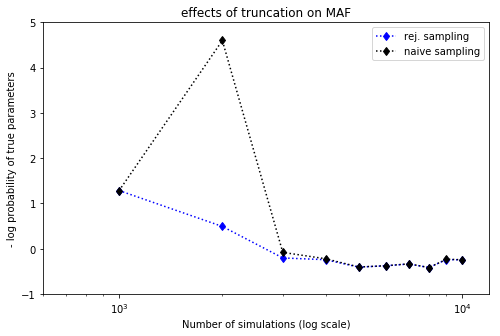

In [6]:
all_prop_errs = calc_all_lprob_errs(pars_true, 
                                    n_samples=5000, 
                                    posteriors=posteriors_C, 
                                    init_g=init_g,
                                    rej=True)

all_prop_errs_raw = calc_all_lprob_errs(pars_true, 
                                    n_samples=5000, 
                                    posteriors=posteriors_C, 
                                    init_g=init_g,
                                    rej=False)

plt.figure(figsize=(8,5))
plt.semilogx(np.arange(1, setup_dict['n_rounds']+1) * setup_dict['n_train'], all_prop_errs, 'bd:')
plt.semilogx(np.arange(1, setup_dict['n_rounds']+1) * setup_dict['n_train'], all_prop_errs_raw, 'kd:')
plt.legend(['rej. sampling', 'naive sampling'])
plt.axis([600, 12000, -1, 5])
plt.xlabel('Number of simulations (log scale)')
plt.ylabel('- log probability of true parameters')
plt.title('effects of truncation on MAF')
#plt.savefig('/home/marcel/Desktop/lv_snpec_maf_n_null_10_N5000_MAF_truncation.pdf')
plt.show()

# store results

In [3]:
save_results(logs=logs_C, tds=tds_C, posteriors=posteriors_C, 
             setup_dict=setup_dict, exp_id=exp_id, path=save_path)

#logs, tds, posteriors, setup_dict = load_results(exp_id=exp_id, path=path)